**Description**: PCA experiment which demonstrates bias with high rank features.

**Estimated runtime**: 5 min.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
sns.set_theme(style="darkgrid")

## Set simluation parameters

These are for generating data from a linear model, where features can be correlated with
each other.

In [3]:
NUM_TRIALS = 2_000

# sample sizes
NUM_TRAIN_OBS = 100  # obs to train linear regression on
NUM_TEST_OBS = list(range(25, 525, 25))  # also the # of obs to fit PCA  

# features
NUM_FEATURES = 20              # keep in mind the number of train and test obs
NUM_FEATURES_INFORMATIVE = 10      # <= NUM_FEATURES
EFFECTIVE_RANKS = [5, 10, 15, 20]  # <= NUM_FEATURES
NUM_PCA_COMPONENTS = [int(0.6 * effective_rank) for effective_rank in EFFECTIVE_RANKS]

# seeds
RANDOM_STATE_GENERATE_DATA = 123
RANDOM_STATE_SPLIT_DATA = 42

# labels
NOISE_ST_DEV = 1.0

## Run simulations

In [4]:
def _split(
    X: np.ndarray,
    y: np.ndarray,
    num_test: int,
    num_train: int = NUM_TRAIN_OBS,
    random_state: int = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, train_size=num_train, random_state=random_state
    )
    random_state = None if random_state is None else random_state + 1
    X_ex, X_te, y_ex, y_te = train_test_split(
        X_te, y_te, train_size=num_test, test_size=num_test, random_state=random_state
    )
    return (X_tr, X_ex, X_te, y_tr, y_ex, y_te)

In [5]:
def _simulation(
    X: np.ndarray,
    y: np.ndarray,
    num_test: int,
    num_pca_components: int,
    num_trials: int = NUM_TRIALS,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    r2s_ba: list[float] = []
    r2s_ex: list[float] = []
    r2s_te: list[float] = []

    for i in range(num_trials):
        X_tr, X_ex, X_te, y_tr, _, y_te = _split(
            X, y, num_test=num_test, random_state=RANDOM_STATE_SPLIT_DATA + i
        )

        def r2_base(X_tr: np.ndarray) -> float:
            return LinearRegression().fit(X_tr, y_tr).score(X_te, y_te)

        def r2_pca(X_for_fitting_pca: np.ndarray) -> float:
            pca = PCA(n_components=num_pca_components).fit(X_for_fitting_pca)
            X_tr_reduced = pca.transform(X_tr)
            model = LinearRegression().fit(X_tr_reduced, y_tr)
            X_te_reduced = pca.transform(X_te)
            return model.score(X_te_reduced, y_te)

        r2s_ba.append(r2_base(X_tr))
        r2s_ex.append(r2_pca(X_ex))
        r2s_te.append(r2_pca(X_te))

    return np.array(r2s_ba), np.array(r2s_ex), np.array(r2s_te)


def simulation(effective_rank: int, num_pca_components: int):
    r2s_ba = []
    r2s_ex = []
    r2s_te = []
    for num_test in tqdm(NUM_TEST_OBS):
        X, y = make_regression(
            n_samples=NUM_TRAIN_OBS + num_test + num_test,
            n_features=NUM_FEATURES,
            n_informative=NUM_FEATURES_INFORMATIVE,
            effective_rank=effective_rank,
            noise=NOISE_ST_DEV,
            random_state=RANDOM_STATE_GENERATE_DATA,
        )
        _r2s_base, _r2s_ex, _r2s_te = _simulation(
            X, y, num_test, num_pca_components
        )
        r2s_ba.append(_r2s_base)
        r2s_ex.append(_r2s_ex)
        r2s_te.append(_r2s_te)
    return np.array(r2s_ba), np.array(r2s_ex), np.array(r2s_te)

In [6]:
paired_diffs_boost: list[np.ndarray] = []
standard_errors_boost: list[np.ndarray] = []

paired_diffs_bias: list[np.ndarray] = []
standard_errors_bias: list[np.ndarray] = []

for i in tqdm(range(len(EFFECTIVE_RANKS)), desc="Simulation"):
    r2s_ba, r2s_ex, r2s_te = simulation(EFFECTIVE_RANKS[i], NUM_PCA_COMPONENTS[i])

    paired_diffs: np.ndarray = r2s_ex - r2s_ba
    standard_errors = np.sqrt(np.var(paired_diffs, axis=1, ddof=1) / r2s_ex.shape[1])
    paired_diffs_boost.append(paired_diffs)
    standard_errors_boost.append(standard_errors)

    paired_diffs: np.ndarray = r2s_te - r2s_ex
    standard_errors = np.sqrt(np.var(paired_diffs, axis=1, ddof=1) / r2s_ex.shape[1])
    paired_diffs_bias.append(paired_diffs)
    standard_errors_bias.append(standard_errors)

Simulation:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
def plot_error_bars(means: np.ndarray, ses: np.ndarray, ylabel: str):
    plt.figure(figsize=(10, 5))

    # ty https://stackoverflow.com/q/61368805/18758987
    for i in reversed(range(len(EFFECTIVE_RANKS))):
        mean = np.mean(means[i], axis=1)
        moe = 1.96 * ses[i]
        label = (
            f"rank = {EFFECTIVE_RANKS[i]}, {'  ' if EFFECTIVE_RANKS[i] < 10 else ''}"
            f"PCA components = {NUM_PCA_COMPONENTS[i]}"
        )
        plt.plot(NUM_TEST_OBS, mean, label=label)
        plt.fill_between(NUM_TEST_OBS, mean - moe, mean + moe, alpha=0.2)

    plt.grid()
    plt.xticks(NUM_TEST_OBS[1::2])
    plt.xlim(min(NUM_TEST_OBS) - 10, max(NUM_TEST_OBS))
    plt.axhline(y=0, color='black', linestyle='--')

    plt.xlabel("$n$ test observations")
    plt.ylabel(
        ylabel + "\n$R^2_{\\text{test}} - R^2_{\\text{extra}}$",
        rotation="horizontal",
        labelpad=40,
    )
    plt.title(
        f"PCA before linear regression ($m = {NUM_TRAIN_OBS}$ training observations)"
    )
    plt.grid()
    plt.legend()

In [8]:
# plot_error_bars(paired_diffs_boost, standard_errors_boost, ylabel="pretraining\nboost")

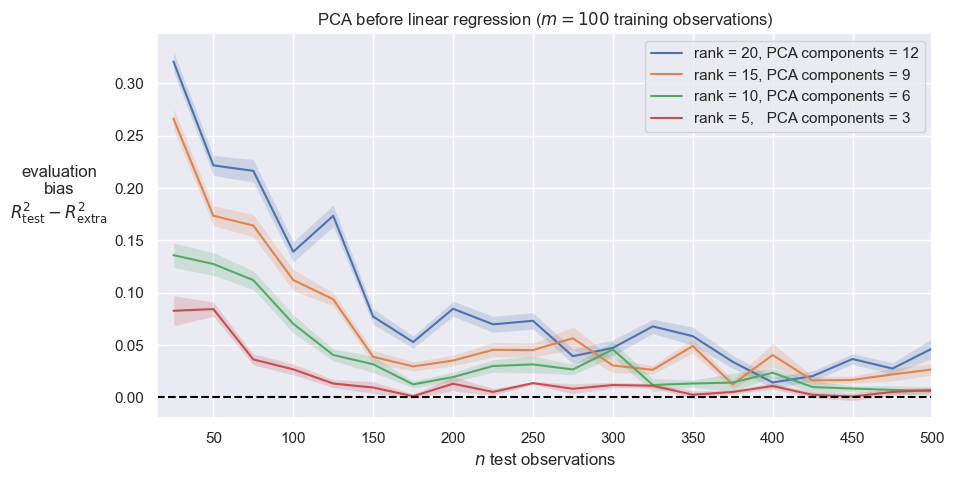

In [9]:
plot_error_bars(paired_diffs_bias, standard_errors_bias, ylabel="evaluation\nbias")